In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy.interpolate import interp1d,RegularGridInterpolator
from scipy.optimize import least_squares
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_network
import ring_network as ring_network
import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')

# Look at 50 First Candidates, Plot VSM vs OSM Rates

In [3]:
font = {'family' : 'normal', 'weight' : 'normal', 'size' : 7, 'family' : 'serif', 'serif' : ['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

with open('./data_moments'+'.pkl', 'rb') as handle:
    data_moments = pickle.load(handle)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    data_contrasts = pickle.load(handle)

def plot_many_preds(all_preds,output_dir,name_end,animal='both',preds_aux=None,plot_delta_r=False):

    if animal=='both':
        animal_idxs=[0,1]
    elif animal in ('mouse','Mouse'):
        animal_idxs=[0]
    elif animal in ('monkey','Monkey'):
        animal_idxs=[1]

    if plot_delta_r:
        rows=5
        n_moment=7
    else:
        rows=4
        n_moment=6
    cols=len(animal_idxs)
    colors=['c','m']
    color_sim=['xkcd:aqua','xkcd:coral']
    fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), dpi=300, facecolor='w', edgecolor='k',
                            sharex=True)
    fig.subplots_adjust(hspace = .5, wspace=.5)
    axs = axs.ravel()
    this_animals=['mouse','monkey']
    
    for idx,anim_idx in enumerate(animal_idxs):
        dataset=data_moments[anim_idx]
        contrast=data_contrasts[anim_idx]
        for pred_idx,preds in enumerate(all_preds[anim_idx]):
            if preds[0].ndim==2:
                predictions=preds
                if preds_aux is not None:
                    predictions_aux=preds_aux
            else:
                predictions=preds
                if preds_aux is not None:
                    predictions_aux=preds_aux
            for idx_moment in range(n_moment):
                if idx_moment<2:
                    idx_row=0
                    ccc=['k',colors[anim_idx]][idx_moment]
                    ccd=['k',color_sim[anim_idx]][idx_moment]
                    ymin=0
                    ymax=[25,80][anim_idx]
                    if preds_aux is not None:
                        ymax=max(ymax,*predictions_aux[:,[0,1]].flatten())
                    ylabel='Mean rate (spk/s)'

                if (idx_moment>=2)&(idx_moment<4):
                    idx_row=1
                    ccc=['k',colors[anim_idx]][idx_moment-2]
                    ccd=['k',color_sim[anim_idx]][idx_moment-2]
                    ymin=0
                    ymax=[20,60][anim_idx]
                    if preds_aux is not None:
                        ymax=max(ymax,*predictions_aux[:,[2,3]].flatten())
                    ylabel='Std rate (spk/s)'

                if (idx_moment==4):
                    idx_row=2
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=0
                    ymax=[20,60][anim_idx]
                    ylabel='Std Δrate (spk/s)'

                if (idx_moment==5):
                    idx_row=3
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=-0.75
                    ymax=0.25
                    ylabel='ρ'

                if (idx_moment==6):
                    idx_row=4
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=[-5,-10][anim_idx]
                    ymax=[20,30][anim_idx]
                    ylabel='Mean Δrate (spk/s)'
                
                m,sem=dataset[idx_moment,:,0],dataset[idx_moment,:,1]
                if pred_idx == 0:
                    axs[cols*idx_row+idx].scatter(contrast,m,facecolors='none', s=10,edgecolors=ccc,marker='o')
                    axs[cols*idx_row+idx].fill_between(contrast,m-sem,m+sem,color=ccc,alpha=0.2)
                    axs[cols*idx_row+idx].set_xscale('symlog', linthresh=12)
                    axs[cols*idx_row+idx].set_ylim([ymin,ymax])
                    axs[cols*idx_row+idx].set_xlabel('contrast (%)')
                    axs[cols*idx_row+idx].set_ylabel(ylabel)
                    if idx_moment >= 5:
                        axs[cols*idx_row+idx].axhline(y=0,ls='--',c='k')
                axs[cols*idx_row+idx].plot(contrast,predictions[:,idx_moment],color=ccc,alpha=0.5)
                if preds_aux is not None:
                    axs[cols*idx_row+idx].plot(contrast,predictions_aux[:,idx_moment],color=ccc,ls='--',alpha=0.5)
    #            if all_moments not None:


    print('Done')

    fig.tight_layout()
    fig.savefig(output_dir+'/many_preds_'+name_end+'.pdf', bbox_inches='tight')
    
def plot_many_preds_with_bal(all_preds,all_bals,all_optrs,output_dir,name_end,animal='both',
                        preds_aux=None,bals_aux=None,optrs_aux=None,plot_delta_r=False):

    if animal=='both':
        animal_idxs=[0,1]
    elif animal in ('mouse','Mouse'):
        animal_idxs=[0]
    elif animal in ('monkey','Monkey'):
        animal_idxs=[1]

    if plot_delta_r:
        rows=7
        n_moment=7
    else:
        rows=6
        n_moment=6
    cols=len(animal_idxs)
    colors=['c','m']
    color_sim=['xkcd:aqua','xkcd:coral']
    fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), dpi=300, facecolor='w', edgecolor='k',
                            sharex=True)
    fig.subplots_adjust(hspace = .5, wspace=.5)
    axs = axs.ravel()
    this_animals=['mouse','monkey']
    
    for idx,anim_idx in enumerate(animal_idxs):
        dataset=data_moments[anim_idx]
        contrast=data_contrasts[anim_idx]
        if preds[0].ndim==2:
            predictions=preds[anim_idx]
            if preds_aux is not None:
                predictions_aux=preds_aux[anim_idx]
        else:
            predictions=preds
            if preds_aux is not None:
                predictions_aux=preds_aux
        for idx_moment in range(n_moment):
            if idx_moment<2:
                idx_row=0
                ccc=['k',colors[anim_idx]][idx_moment]
                ccd=['k',color_sim[anim_idx]][idx_moment]
                ymin=0
                ymax=[25,80][anim_idx]
                if preds_aux is not None:
                    ymax=max(ymax,*predictions_aux[:,[0,1]].flatten())
                ylabel='Mean rate (spk/s)'

            if (idx_moment>=2)&(idx_moment<4):
                idx_row=1
                ccc=['k',colors[anim_idx]][idx_moment-2]
                ccd=['k',color_sim[anim_idx]][idx_moment-2]
                ymin=0
                ymax=[20,60][anim_idx]
                if preds_aux is not None:
                    ymax=max(ymax,*predictions_aux[:,[2,3]].flatten())
                ylabel='Std rate (spk/s)'

            if (idx_moment==4):
                idx_row=2
                ccc=colors[anim_idx]
                ccd=color_sim[anim_idx]
                ymin=0
                ymax=[20,60][anim_idx]
                ylabel='Std Δrate (spk/s)'

            if (idx_moment==5):
                idx_row=3
                ccc=colors[anim_idx]
                ccd=color_sim[anim_idx]
                ymin=-0.75
                ymax=0.25
                ylabel='ρ'

            if (idx_moment==6):
                idx_row=4
                ccc=colors[anim_idx]
                ccd=color_sim[anim_idx]
                ymin=[-5,-10][anim_idx]
                ymax=[20,30][anim_idx]
                ylabel='Mean Δrate (spk/s)'
            
            m,sem=dataset[idx_moment,:,0],dataset[idx_moment,:,1]
            axs[cols*idx_row+idx].scatter(contrast,m,facecolors='none', s=10,edgecolors=ccc,marker='o')
            axs[cols*idx_row+idx].fill_between(contrast,m-sem,m+sem,color=ccc,alpha=0.2)
            axs[cols*idx_row+idx].plot(contrast,predictions[:,idx_moment],color=ccc,alpha=1.)
            if preds_aux is not None:
                axs[cols*idx_row+idx].plot(contrast,predictions_aux[:,idx_moment],color=ccc,ls='--',alpha=1.)
#            if all_moments not None:
            if idx_moment >= 5:
                axs[cols*idx_row+idx].axhline(y=0,ls='--',c='k')

            axs[cols*idx_row+idx].set_xscale('symlog', linthresh=12)
            axs[cols*idx_row+idx].set_ylim([ymin,ymax])
            axs[cols*idx_row+idx].set_xlabel('contrast (%)')
            axs[cols*idx_row+idx].set_ylabel(ylabel)
    
    for idx,anim_idx in enumerate(animal_idxs):
        contrast=data_contrasts[anim_idx]
        if preds[0].ndim==2:
            animal_balance=bals[anim_idx]
            animal_optorat=optrs[anim_idx]
            if bals_aux:
                animal_balance_aux=bals_aux[anim_idx]
            if optrs_aux:
                animal_optorat_aux=optrs_aux[anim_idx]
        else:
            animal_balance=bals
            animal_optorat=optrs
            if bals_aux is not None:
                animal_balance_aux=bals_aux
            if optrs_aux is not None:
                animal_optorat_aux=optrs_aux
        for idx_row in range(rows-2,rows):
            ccc=colors[anim_idx]
            ccd=color_sim[anim_idx]
            if idx_row==rows-2:
                ylabel='Balance index β'
                y=animal_balance
                if bals_aux is not None:
                    y_aux=animal_balance_aux
                ymin=1e-2
                ymax=1e0
            elif idx_row==rows-1:
                ylabel='Opto Input Ratio'
                y=animal_optorat
                if optrs_aux is not None:
                    y_aux=animal_optorat_aux
                ymin=2e-3
                ymax=2e-1
            try:
                axs[cols*idx_row+idx].plot(contrast,y[:,anim_idx],color=ccc,alpha=1.)
                if (idx_row==4 and bals_aux is not None) or (idx_row==5 and optrs_aux is not None):
                    axs[cols*idx_row+idx].plot(contrast,y_aux[:,anim_idx],color=ccc,ls='--',alpha=1.)
            except:
                axs[cols*idx_row+idx].plot(contrast,y,color=ccc,alpha=1.)
                if (idx_row==4 and bals_aux is not None) or (idx_row==5 and optrs_aux is not None):
                    axs[cols*idx_row+idx].plot(contrast,y_aux,color=ccc,ls='--',alpha=1.)
            # axs[cols*idx_row+idx].plot(contrast,y[:,0],'-',color=ccc,alpha=1.)
            # axs[cols*idx_row+idx].plot(contrast,y[:,1],'--',color=ccc,alpha=1.)
            axs[cols*idx_row+idx].set_xscale('symlog', linthresh=12)
            axs[cols*idx_row+idx].set_yscale('log')
            axs[cols*idx_row+idx].set_ylim([ymin,ymax])
            axs[cols*idx_row+idx].set_xlabel('contrast (%)')
            axs[cols*idx_row+idx].set_ylabel(ylabel)


    print('Done')

    fig.tight_layout()
    fig.savefig(output_dir+'/preds_with_bal_'+name_end+'.pdf', bbox_inches='tight')

In [4]:
max_njob = 50

candidate_njobs = []
candidate_prms = []
candidate_aXs = []
candidate_vsm_preds = []
candidate_osm_preds = []
candidate_costs = []
candidate_in_bars = []
candidate_idxs = []

monk_base_means =       np.array([20.38, 43.32, 54.76, 64.54, 70.97, 72.69])
monk_base_stds =        np.array([17.06, 32.41, 38.93, 42.76, 45.17, 48.61])
monk_opto_means =       np.array([30.82, 44.93, 53.36, 60.46, 64.09, 68.87])
monk_opto_stds =        np.array([36.36, 42.87, 45.13, 49.31, 47.53, 52.24])
monk_diff_means =       np.array([10.44,  1.61, -1.41, -4.08, -6.88, -3.82])
monk_diff_stds =        np.array([37.77, 42.48, 42.24, 45.43, 41.78, 41.71])
monk_norm_covs =        np.array([-0.1456, -0.2999, -0.3792, -0.3831, -0.4664, -0.4226])

monk_base_means_err =   np.array([ 2.39,  4.49,  5.38,  5.90,  6.22,  6.69])
monk_base_stds_err =    np.array([ 2.29,  3.67,  4.48,  5.10,  5.61,  5.32])
monk_opto_means_err =   np.array([ 5.03,  5.86,  6.16,  6.74,  6.50,  7.15])
monk_opto_stds_err =    np.array([ 7.73,  6.47,  5.90,  6.20,  4.93,  4.74])
monk_diff_means_err =   np.array([ 5.28,  5.90,  5.84,  6.28,  5.75,  5.76])
monk_diff_stds_err =    np.array([ 8.36,  8.74,  8.01, 10.04,  8.51,  8.94])
monk_norm_covs_err =    np.array([ 0.1075,  0.1354,  0.1579,  0.1496,  0.1717,  0.1665])

def refit_contrast(aXs,vsm_preds,osm_preds):
    vsm_base_mean_itp = interp1d(aXs, vsm_preds[0])
    vsm_base_std_itp = interp1d(aXs, vsm_preds[1])
    vsm_opto_mean_itp = interp1d(aXs, vsm_preds[2])
    vsm_opto_std_itp = interp1d(aXs, vsm_preds[3])
    vsm_diff_mean_itp = interp1d(aXs, vsm_preds[-1])
    vsm_diff_std_itp = interp1d(aXs, vsm_preds[4])
    vsm_norm_cov_itp = interp1d(aXs, vsm_preds[5])
    
    osm_base_mean_itp = interp1d(aXs, osm_preds[0])
    osm_base_std_itp = interp1d(aXs, osm_preds[1])
    osm_opto_mean_itp = interp1d(aXs, osm_preds[2])
    osm_opto_std_itp = interp1d(aXs, osm_preds[3])
    osm_diff_mean_itp = interp1d(aXs, osm_preds[-1])
    osm_diff_std_itp = interp1d(aXs, osm_preds[4])
    osm_norm_cov_itp = interp1d(aXs, osm_preds[5])
    
    def residuals(x):
        pred_base_means = vsm_base_mean_itp(np.concatenate(([0],x)))
        pred_base_stds = vsm_base_std_itp(np.concatenate(([0],x)))
        pred_opto_means = vsm_opto_mean_itp(np.concatenate(([0],x)))
        pred_opto_stds = vsm_opto_std_itp(np.concatenate(([0],x)))
        pred_diff_means = vsm_diff_mean_itp(np.concatenate(([0],x)))
        pred_diff_stds = vsm_diff_std_itp(np.concatenate(([0],x)))
        pred_norm_covs = vsm_norm_cov_itp(np.concatenate(([0],x)))
        res = np.array([(pred_base_means-monk_base_means)/monk_base_means_err,
                        (pred_base_stds-monk_base_stds)/monk_base_stds_err,
                        (pred_opto_means-monk_opto_means)/monk_opto_means_err,
                        (pred_opto_stds-monk_opto_stds)/monk_opto_stds_err,
                        # (pred_diff_means-monk_diff_means)/monk_diff_means_err,
                        (pred_diff_stds-monk_diff_stds)/monk_diff_stds_err,
                        (pred_norm_covs-monk_norm_covs)/monk_norm_covs_err])
        return np.concatenate((res.ravel(),[10*np.sum(np.fmin(0,x[1:]-x[:-1]))]))
    xmin = aXs[ 0]*np.ones(5)
    xmax = aXs[-1]*np.ones(5)
    x0 = np.linspace(aXs[1],aXs[-1],5)
    results = least_squares(residuals,x0,bounds=(xmin,xmax))
    pred_base_means = vsm_base_mean_itp(np.concatenate(([0],results.x)))
    pred_base_stds = vsm_base_std_itp(np.concatenate(([0],results.x)))
    pred_opto_means = vsm_opto_mean_itp(np.concatenate(([0],results.x)))
    pred_opto_stds = vsm_opto_std_itp(np.concatenate(([0],results.x)))
    pred_diff_means = vsm_diff_mean_itp(np.concatenate(([0],results.x)))
    pred_diff_stds = vsm_diff_std_itp(np.concatenate(([0],results.x)))
    pred_norm_covs = vsm_norm_cov_itp(np.concatenate(([0],results.x)))
    res = np.array([(pred_base_means-monk_base_means)/monk_base_means_err,
                        (pred_base_stds-monk_base_stds)/monk_base_stds_err,
                        (pred_opto_means-monk_opto_means)/monk_opto_means_err,
                        (pred_opto_stds-monk_opto_stds)/monk_opto_stds_err,
                        # (pred_diff_means-monk_diff_means)/monk_diff_means_err,
                        (pred_diff_stds-monk_diff_stds)/monk_diff_stds_err,
                        (pred_norm_covs-monk_norm_covs)/monk_norm_covs_err])
    return (np.vstack((vsm_base_mean_itp(np.concatenate(([0],results.x))),
            vsm_base_std_itp(np.concatenate(([0],results.x))),
            vsm_opto_mean_itp(np.concatenate(([0],results.x))),
            vsm_opto_std_itp(np.concatenate(([0],results.x))),
            vsm_diff_std_itp(np.concatenate(([0],results.x))),
            vsm_norm_cov_itp(np.concatenate(([0],results.x))),
            vsm_diff_mean_itp(np.concatenate(([0],results.x))))).T,
            np.vstack((osm_base_mean_itp(np.concatenate(([0],results.x))),
            osm_base_std_itp(np.concatenate(([0],results.x))),
            osm_opto_mean_itp(np.concatenate(([0],results.x))),
            osm_opto_std_itp(np.concatenate(([0],results.x))),
            osm_diff_std_itp(np.concatenate(([0],results.x))),
            osm_norm_cov_itp(np.concatenate(([0],results.x))),
            osm_diff_mean_itp(np.concatenate(([0],results.x))))).T,np.concatenate(([0],results.x)),0.5*np.sum(res**2))

for njob in range(max_njob):
    try:
        with open('./../results/refit_candidate_prms/refit_candidate_prms_narrow_{:d}'.format(njob)+'.pkl', 'rb') as handle:
            this_res_dict = pickle.load(handle)
        orig_aXs = this_res_dict['best_monk_aXs']
        with open('./../results/refit_candidate_prms/candidate_prms_baseline_supp_{:d}'.format(njob)+'.pkl', 'rb') as handle:
            this_res_dict = pickle.load(handle)
        candidate_njobs.append(njob)
        this_prms = np.array(list(this_res_dict['prms'].values()))[1:12]
        this_prms[3] = np.log10(this_prms[3])
        this_prms[4] = np.log10(this_prms[4])
        this_prms[10] = np.log10(this_prms[10])
        candidate_prms.append(this_prms)
        this_vsm,this_osm,this_aXs,_ = refit_contrast(orig_aXs,np.vstack((this_res_dict['vsm_base_means'],
                                          this_res_dict['vsm_opto_means'],
                                          this_res_dict['vsm_base_stds'],
                                          this_res_dict['vsm_opto_stds'],
                                          this_res_dict['vsm_diff_stds'],
                                          this_res_dict['vsm_norm_covs'],
                                          this_res_dict['vsm_diff_means'])),
                                             np.vstack((this_res_dict['osm_base_means'],
                                          this_res_dict['osm_opto_means'],
                                          this_res_dict['osm_base_stds'],
                                          this_res_dict['osm_opto_stds'],
                                          this_res_dict['osm_diff_stds'],
                                          this_res_dict['osm_norm_covs'],
                                          this_res_dict['osm_diff_means'])))
        candidate_aXs.append(this_aXs)
        candidate_vsm_preds.append(this_vsm)
        candidate_osm_preds.append(this_osm)
        this_resid = np.array(np.vstack(((this_vsm[:,0]-monk_base_means)/monk_base_means_err,
                                         (this_vsm[:,1]-monk_opto_means)/monk_opto_means_err,
                                         (this_vsm[:,2]-monk_base_stds)/monk_base_stds_err,
                                         (this_vsm[:,3]-monk_opto_stds)/monk_opto_stds_err,
                                         (this_vsm[:,4]-monk_diff_stds)/monk_diff_stds_err,
                                         (this_vsm[:,5]-monk_norm_covs)/monk_norm_covs_err)))
        candidate_costs.append(0.5*np.sum(this_resid**2))
        candidate_in_bars.append(np.sum(np.abs(this_resid),1) < 6)
        try:
            candidate_idxs.append(this_res_dict['idx'])
        except:
            candidate_idxs.append((None,None))
    except:
        pass
    
candidate_njobs = np.array(candidate_njobs)
candidate_prms = np.array(candidate_prms)
candidate_aXs = np.array(candidate_aXs)
candidate_vsm_preds = np.array(candidate_vsm_preds)
candidate_osm_preds = np.array(candidate_osm_preds)
candidate_costs = np.array(candidate_costs)
candidate_in_bars = np.array(candidate_in_bars)
candidate_idxs = np.array(candidate_idxs)

# Find Best Fit, Refine Inputs

(array([], dtype=int64),)
[0]
[['results_ring_perturb_njob-133_nrep-0_ntry-79.pkl' '3']]
[18.17942536]
[[0.         2.35543409 3.41912176 4.16236209 4.89433708 5.24794174]]
Done


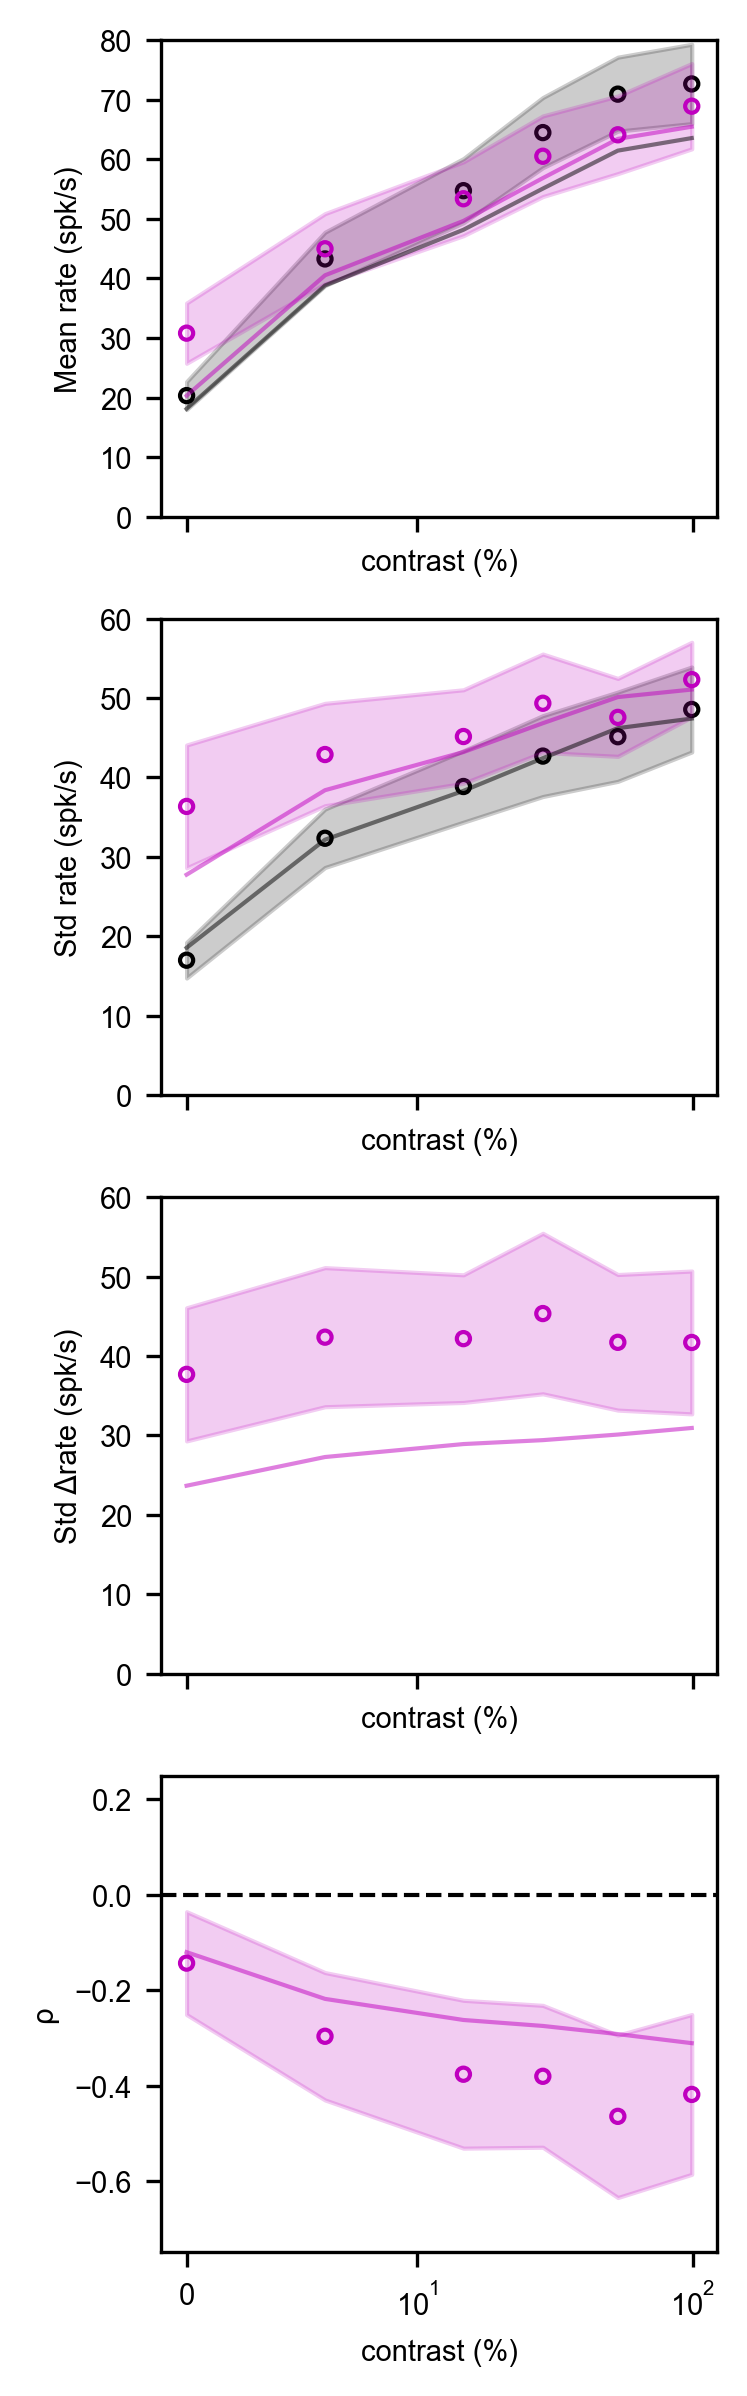

In [5]:
candidate_loss_cut = 19
# chosen_idxs = candidate_costs < candidate_loss_cut
chosen_idxs = [0]
# chosen_idxs = np.logical_and(candidate_costs < candidate_loss_cut,candidate_in_bars[:,-1])
# chosen_idxs = np.logical_and(candidate_costs < candidate_loss_cut,np.logical_and(candidate_in_bars[:,-2],candidate_in_bars[:,-1]))
# chosen_idxs = np.all(candidate_in_bars,1)
# chosen_idxs = np.logical_and(candidate_in_bars[:,-2],candidate_in_bars[:,-1])
# chosen_idxs = np.logical_and(candidate_preds[:,-1,4] > 32,candidate_preds[:,-1,5] < -0.25)
# chosen_idxs = np.logical_and([True if file[0] is not None and 'results_ring_perturb_njob-291_nrep-1' in file[0] else False for file in candidate_idxs],np.logical_and(candidate_preds[:,-1,4] > 35,candidate_preds[:,-1,5] < -0.3))
print(np.where(chosen_idxs))
print(candidate_njobs[chosen_idxs])
print(candidate_idxs[chosen_idxs])
print(candidate_costs[chosen_idxs])
print(candidate_aXs[chosen_idxs])

plot_many_preds([candidate_vsm_preds[chosen_idxs],
                 candidate_vsm_preds[chosen_idxs]],'./../plots','candidate_fits_vsm',animal='monkey',
    plot_delta_r=False)

In [175]:
costs = np.zeros((1,3,3))
for i,SoriEx in enumerate([1.0,]):
    for j,SoriIx in enumerate([1.0,1.1,1.2]):
        for k,SoriFx in enumerate([1.0,1.1,1.2]):
            nc = 7

            sim_vsm_base_means = np.zeros((nc))
            sim_vsm_base_stds = np.zeros((nc))
            sim_vsm_opto_means = np.zeros((nc))
            sim_vsm_opto_stds = np.zeros((nc))
            sim_vsm_diff_means = np.zeros((nc))
            sim_vsm_diff_stds = np.zeros((nc))
            sim_vsm_norm_covs = np.zeros((nc))
            sim_osm_base_means = np.zeros((nc))
            sim_osm_base_stds = np.zeros((nc))
            sim_osm_opto_means = np.zeros((nc))
            sim_osm_opto_stds = np.zeros((nc))
            sim_osm_diff_means = np.zeros((nc))
            sim_osm_diff_stds = np.zeros((nc))
            sim_osm_norm_covs = np.zeros((nc))

            with open('./../results/best_fit'+'.pkl', 'rb') as handle:
                res_dict = pickle.load(handle)
            sim_aXs = res_dict['best_monk_aXs']
            sim_aXs = np.concatenate([sim_aXs,sim_aXs[-1]*np.arange(1.0+0.2,2.0+0.2,0.2)])[:nc]
            sim_bX = res_dict['best_monk_bX']
            sim_eX = res_dict['best_monk_eX']
            sim_prms = res_dict['prms']
            
            res_file = './../results/best_fit_1s_id_None'
            if not np.isclose(SoriEx,1.0):
                res_file = res_file + '_SoriEx{:.2f}'.format(SoriEx)
            if not np.isclose(SoriIx,1.0):
                res_file = res_file + '_SoriIx{:.2f}'.format(SoriIx)
            if not np.isclose(SoriFx,1.0):
                res_file = res_file + '_SoriFx{:.2f}'.format(SoriFx)

            for c_idx in range(nc):
                try:
                    with open(res_file+'_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                            handle:
                        res_dict = pickle.load(handle)
                    sim_vsm_base_means[c_idx] = res_dict['vsm_base_means']
                    sim_vsm_base_stds[c_idx] = res_dict['vsm_base_stds']
                    sim_vsm_opto_means[c_idx] = res_dict['vsm_opto_means']
                    sim_vsm_opto_stds[c_idx] = res_dict['vsm_opto_stds']
                    sim_vsm_diff_means[c_idx] = res_dict['vsm_diff_means']
                    sim_vsm_diff_stds[c_idx] = res_dict['vsm_diff_stds']
                    sim_vsm_norm_covs[c_idx] = res_dict['vsm_norm_covs']
                    sim_osm_base_means[c_idx] = res_dict['osm_base_means']
                    sim_osm_base_stds[c_idx] = res_dict['osm_base_stds']
                    sim_osm_opto_means[c_idx] = res_dict['osm_opto_means']
                    sim_osm_opto_stds[c_idx] = res_dict['osm_opto_stds']
                    sim_osm_diff_means[c_idx] = res_dict['osm_diff_means']
                    sim_osm_diff_stds[c_idx] = res_dict['osm_diff_stds']
                    sim_osm_norm_covs[c_idx] = res_dict['osm_norm_covs']
                    
                except:
                    sim_vsm_base_means[c_idx] = np.nan
                    sim_vsm_base_stds[c_idx] = np.nan
                    sim_vsm_opto_means[c_idx] = np.nan
                    sim_vsm_opto_stds[c_idx] = np.nan
                    sim_vsm_diff_means[c_idx] = np.nan
                    sim_vsm_diff_stds[c_idx] = np.nan
                    sim_vsm_norm_covs[c_idx] = np.nan
                    sim_osm_base_means[c_idx] = np.nan
                    sim_osm_base_stds[c_idx] = np.nan
                    sim_osm_opto_means[c_idx] = np.nan
                    sim_osm_opto_stds[c_idx] = np.nan
                    sim_osm_diff_means[c_idx] = np.nan
                    sim_osm_diff_stds[c_idx] = np.nan
                    sim_osm_norm_covs[c_idx] = np.nan
                    
            c_idxs = np.logical_not(np.isnan(sim_vsm_base_means))
            sim_aXs = sim_aXs[c_idxs]
            sim_vsm_base_means = sim_vsm_base_means[c_idxs]
            sim_vsm_opto_means = sim_vsm_opto_means[c_idxs]
            sim_vsm_base_stds = sim_vsm_base_stds[c_idxs]
            sim_vsm_opto_stds = sim_vsm_opto_stds[c_idxs]
            sim_vsm_diff_stds = sim_vsm_diff_stds[c_idxs]
            sim_vsm_norm_covs = sim_vsm_norm_covs[c_idxs]
            sim_vsm_diff_means = sim_vsm_diff_means[c_idxs]
            sim_osm_base_means = sim_osm_base_means[c_idxs]
            sim_osm_opto_means = sim_osm_opto_means[c_idxs]
            sim_osm_base_stds = sim_osm_base_stds[c_idxs]
            sim_osm_opto_stds = sim_osm_opto_stds[c_idxs]
            sim_osm_diff_stds = sim_osm_diff_stds[c_idxs]
            sim_osm_norm_covs = sim_osm_norm_covs[c_idxs]
            sim_osm_diff_means = sim_osm_diff_means[c_idxs]

            old_vsm = np.vstack((sim_vsm_base_means,
                sim_vsm_opto_means,
                sim_vsm_base_stds,
                sim_vsm_opto_stds,
                sim_vsm_diff_stds,
                sim_vsm_norm_covs,
                sim_vsm_diff_means))
                    
            old_osm = np.vstack((sim_osm_base_means,
                sim_osm_opto_means,
                sim_osm_base_stds,
                sim_osm_opto_stds,
                sim_osm_diff_stds,
                sim_osm_norm_covs,
                sim_osm_diff_means))
                    
            new_vsm,new_osm,new_aXs,_ = refit_contrast(sim_aXs,old_vsm,old_osm)
            
            this_resid = np.array(np.vstack(((new_vsm[:,0]-monk_base_means)/monk_base_means_err,
                                            (new_vsm[:,1]-monk_opto_means)/monk_opto_means_err,
                                            (new_vsm[:,2]-monk_base_stds)/monk_base_stds_err,
                                            (new_vsm[:,3]-monk_opto_stds)/monk_opto_stds_err,
                                            (new_vsm[:,4]-monk_diff_stds)/monk_diff_stds_err,
                                            (new_vsm[:,5]-monk_norm_covs)/monk_norm_covs_err)))
            new_cost = 0.5*np.sum(this_resid**2)
            
            costs[i,j,k] = new_cost

In [176]:
costs

array([[[20.912461  , 22.63136122, 24.28142207],
        [21.50632164, 22.6665306 , 24.25623104],
        [21.49634699, 22.80741277, 24.69708466]]])

In [177]:
nc = 7

sim_vsm_base_means = np.zeros((nc))
sim_vsm_base_stds = np.zeros((nc))
sim_vsm_opto_means = np.zeros((nc))
sim_vsm_opto_stds = np.zeros((nc))
sim_vsm_diff_means = np.zeros((nc))
sim_vsm_diff_stds = np.zeros((nc))
sim_vsm_norm_covs = np.zeros((nc))
sim_osm_base_means = np.zeros((nc))
sim_osm_base_stds = np.zeros((nc))
sim_osm_opto_means = np.zeros((nc))
sim_osm_opto_stds = np.zeros((nc))
sim_osm_diff_means = np.zeros((nc))
sim_osm_diff_stds = np.zeros((nc))
sim_osm_norm_covs = np.zeros((nc))

with open('./../results/best_fit'+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)
sim_aXs = res_dict['best_monk_aXs']
sim_aXs = np.concatenate([sim_aXs,sim_aXs[-1]*np.arange(1.0+0.2,2.0+0.2,0.2)])[:nc]
sim_bX = res_dict['best_monk_bX']
sim_eX = res_dict['best_monk_eX']
sim_prms = res_dict['prms']

SoriEx = 1.0
SoriIx = 1.2
SoriFx = 1.0
Jx = 1.0#0.9
betax = 1.0#0.9
gEx = 1.0#1.11
gIx = 1.0
hEx = 1.0#1.19
hIx = 1.0
Lx = 1.0
CVLx = 1.0

res_file = './../results/best_fit_1s_id_None'
# res_file = './../results/dmft_best_fit_id_None'
if not np.isclose(SoriEx,1.0):
    res_file = res_file + '_SoriEx{:.2f}'.format(SoriEx)
if not np.isclose(SoriIx,1.0):
    res_file = res_file + '_SoriIx{:.2f}'.format(SoriIx)
if not np.isclose(SoriFx,1.0):
    res_file = res_file + '_SoriFx{:.2f}'.format(SoriFx)
if not np.isclose(Jx,1.0):
    res_file = res_file + '_Jx{:.2f}'.format(Jx)
if not np.isclose(betax,1.0):
    res_file = res_file + '_betax{:.2f}'.format(betax)
if not np.isclose(gEx,1.0):
    res_file = res_file + '_gEx{:.2f}'.format(gEx)
if not np.isclose(gIx,1.0):
    res_file = res_file + '_gIx{:.2f}'.format(gIx)
if not np.isclose(hEx,1.0):
    res_file = res_file + '_hEx{:.2f}'.format(hEx)
if not np.isclose(hIx,1.0):
    res_file = res_file + '_hIx{:.2f}'.format(hIx)
if not np.isclose(Lx,1.0):
    res_file = res_file + '_Lx{:.2f}'.format(Lx)
if not np.isclose(CVLx,1.0):
    res_file = res_file + '_CVLx{:.2f}'.format(CVLx)
print(res_file)

for c_idx in range(nc):
    try:
        with open(res_file+'_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)
        sim_vsm_base_means[c_idx] = res_dict['vsm_base_means']
        sim_vsm_base_stds[c_idx] = res_dict['vsm_base_stds']
        sim_vsm_opto_means[c_idx] = res_dict['vsm_opto_means']
        sim_vsm_opto_stds[c_idx] = res_dict['vsm_opto_stds']
        sim_vsm_diff_means[c_idx] = res_dict['vsm_diff_means']
        sim_vsm_diff_stds[c_idx] = res_dict['vsm_diff_stds']
        sim_vsm_norm_covs[c_idx] = res_dict['vsm_norm_covs']
        sim_osm_base_means[c_idx] = res_dict['osm_base_means']
        sim_osm_base_stds[c_idx] = res_dict['osm_base_stds']
        sim_osm_opto_means[c_idx] = res_dict['osm_opto_means']
        sim_osm_opto_stds[c_idx] = res_dict['osm_opto_stds']
        sim_osm_diff_means[c_idx] = res_dict['osm_diff_means']
        sim_osm_diff_stds[c_idx] = res_dict['osm_diff_stds']
        sim_osm_norm_covs[c_idx] = res_dict['osm_norm_covs']
        
    except:
        sim_vsm_base_means[c_idx] = np.nan
        sim_vsm_base_stds[c_idx] = np.nan
        sim_vsm_opto_means[c_idx] = np.nan
        sim_vsm_opto_stds[c_idx] = np.nan
        sim_vsm_diff_means[c_idx] = np.nan
        sim_vsm_diff_stds[c_idx] = np.nan
        sim_vsm_norm_covs[c_idx] = np.nan
        sim_osm_base_means[c_idx] = np.nan
        sim_osm_base_stds[c_idx] = np.nan
        sim_osm_opto_means[c_idx] = np.nan
        sim_osm_opto_stds[c_idx] = np.nan
        sim_osm_diff_means[c_idx] = np.nan
        sim_osm_diff_stds[c_idx] = np.nan
        sim_osm_norm_covs[c_idx] = np.nan
        
c_idxs = np.logical_not(np.isnan(sim_vsm_base_means))
sim_aXs = sim_aXs[c_idxs]
sim_vsm_base_means = sim_vsm_base_means[c_idxs]
sim_vsm_opto_means = sim_vsm_opto_means[c_idxs]
sim_vsm_base_stds = sim_vsm_base_stds[c_idxs]
sim_vsm_opto_stds = sim_vsm_opto_stds[c_idxs]
sim_vsm_diff_stds = sim_vsm_diff_stds[c_idxs]
sim_vsm_norm_covs = sim_vsm_norm_covs[c_idxs]
sim_vsm_diff_means = sim_vsm_diff_means[c_idxs]
sim_osm_base_means = sim_osm_base_means[c_idxs]
sim_osm_opto_means = sim_osm_opto_means[c_idxs]
sim_osm_base_stds = sim_osm_base_stds[c_idxs]
sim_osm_opto_stds = sim_osm_opto_stds[c_idxs]
sim_osm_diff_stds = sim_osm_diff_stds[c_idxs]
sim_osm_norm_covs = sim_osm_norm_covs[c_idxs]
sim_osm_diff_means = sim_osm_diff_means[c_idxs]

old_vsm = np.vstack((sim_vsm_base_means,
    sim_vsm_opto_means,
    sim_vsm_base_stds,
    sim_vsm_opto_stds,
    sim_vsm_diff_stds,
    sim_vsm_norm_covs,
    sim_vsm_diff_means))
        
old_osm = np.vstack((sim_osm_base_means,
    sim_osm_opto_means,
    sim_osm_base_stds,
    sim_osm_opto_stds,
    sim_osm_diff_stds,
    sim_osm_norm_covs,
    sim_osm_diff_means))
    
new_vsm,new_osm,new_aXs,_ = refit_contrast(sim_aXs,old_vsm,old_osm)

this_resid = np.array(np.vstack(((new_vsm[:,0]-monk_base_means)/monk_base_means_err,
                                (new_vsm[:,1]-monk_opto_means)/monk_opto_means_err,
                                (new_vsm[:,2]-monk_base_stds)/monk_base_stds_err,
                                (new_vsm[:,3]-monk_opto_stds)/monk_opto_stds_err,
                                (new_vsm[:,4]-monk_diff_stds)/monk_diff_stds_err,
                                (new_vsm[:,5]-monk_norm_covs)/monk_norm_covs_err)))
new_cost = 0.5*np.sum(this_resid**2)

print(new_vsm[-1,1])

./../results/best_fit_1s_id_None_SoriIx1.20
60.51753740139648


In [178]:
sim_prms

{'K': 500,
 'SoriE': 43.64874397050553,
 'SoriI': 19.762766061548188,
 'SoriF': 18.319783509742784,
 'J': 0.0001563477555477658,
 'beta': 0.11430243102629813,
 'gE': 5.950020178827337,
 'gI': 2.6064265565889126,
 'hE': 4.944829366729805,
 'hI': 0.14751926973057156,
 'L': 5.482675876659675,
 'CVL': 3.2538001583918414,
 'Nori': 20,
 'NE': 400,
 'NI': 100}

In [179]:
print(new_cost)

21.496346992191278


[0.         2.99164008 4.08125932 4.9857862  5.42585865 5.68509238]
[0.         3.30629524 5.40280958 6.11965919 7.34359102]
[0.         2.60399319 3.66974806 4.35237638 4.7676374  4.97675518]
Done


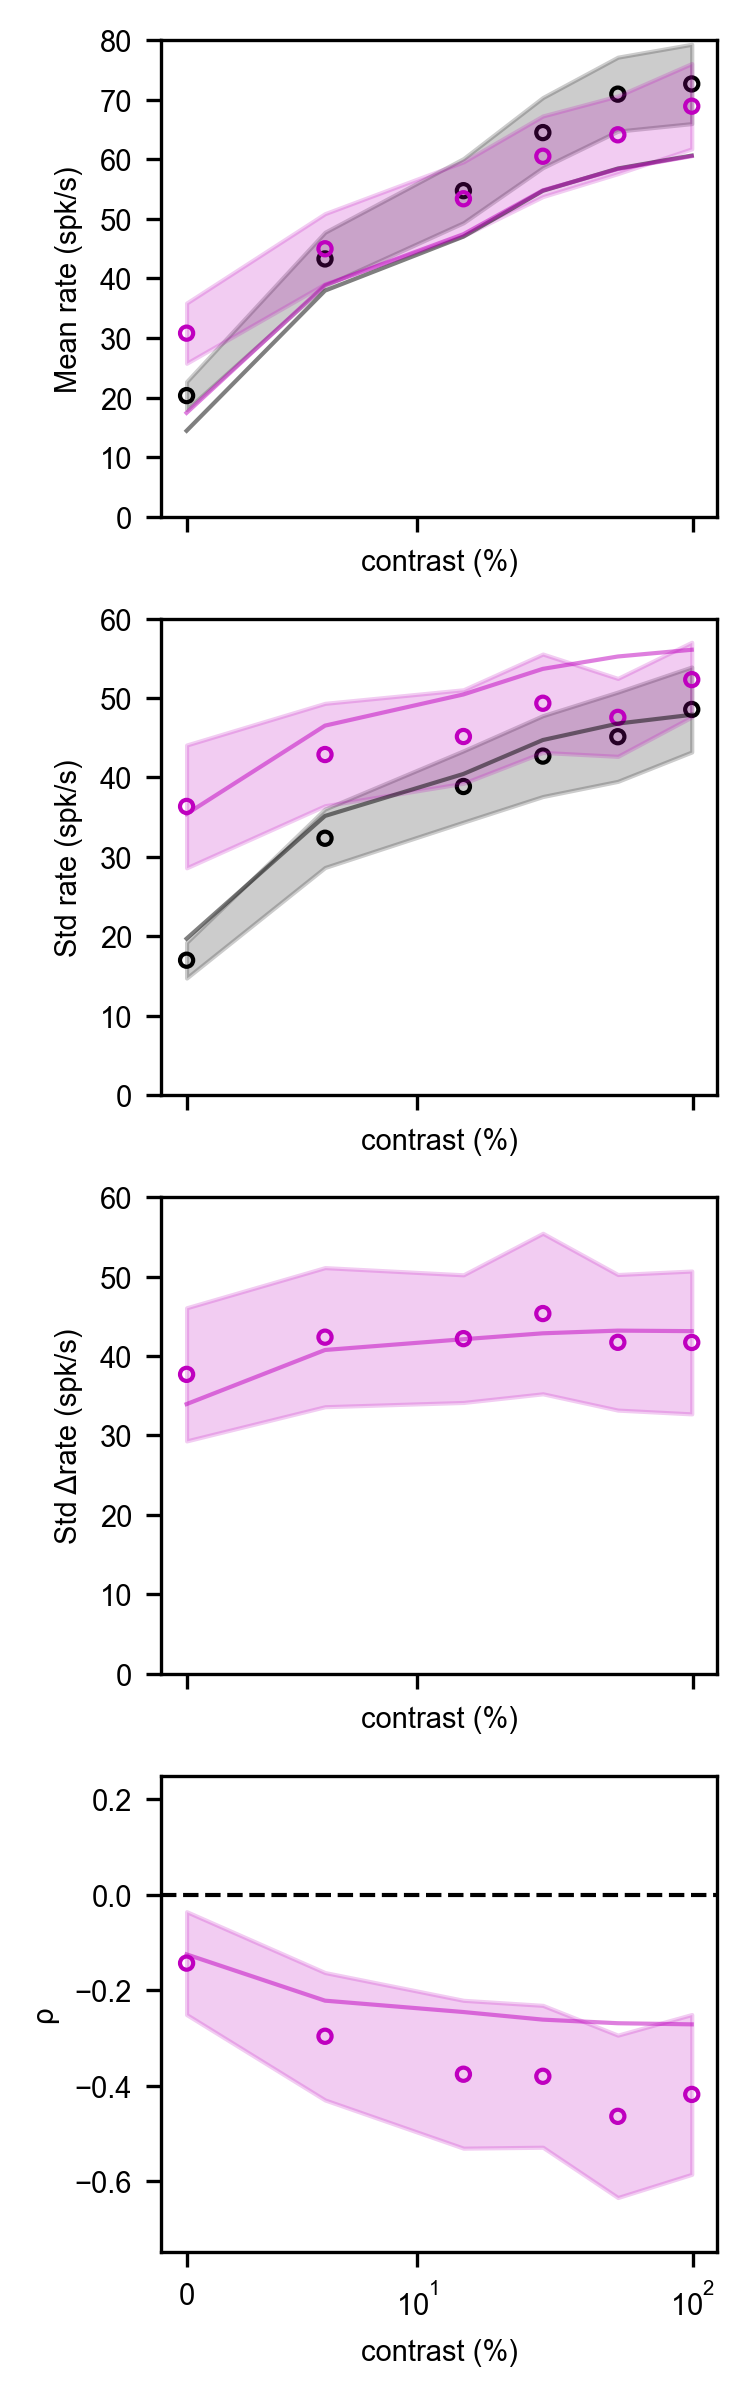

In [180]:
print(new_aXs)
print(sim_aXs)
print(candidate_aXs[20])

plot_many_preds([[new_vsm],[new_vsm]],'./../plots','best_candidate_fit_vsm',animal='monkey',plot_delta_r=False)
# plot_many_preds([[new_vsm],[old_vsm[:,:6].T]],'./../plots','best_candidate_fit_vsm',animal='monkey',plot_delta_r=False)

In [161]:
# with open('./../results/best_fit.pkl', 'wb') as handle:
#     new_prms = sim_prms.copy()
#     new_prms['SoriE'] = new_prms['SoriE'] * 1.0
#     new_prms['SoriI'] = new_prms['SoriI'] * 1.0
#     new_prms['SoriF'] = new_prms['SoriF'] * 1.0
#     new_prms['J'] = new_prms['J'] * 0.9
#     new_prms['beta'] = new_prms['beta'] * 0.9
#     new_prms['gE'] = new_prms['gE'] * 1.0/0.9
#     new_prms['hE'] = new_prms['hE'] * 1.07/0.9
#     new_prms['hI'] = new_prms['hI'] * 1.0
#     this_dict = {'prms'          : new_prms,
#                  'best_monk_eX'  : sim_eX,
#                  'best_monk_bX'  : sim_bX,
#                  'best_monk_aXs' : new_aXs}
    
#     pickle.dump(this_dict,handle)

In [20]:
with open('./../results/old_best_fit'+'.pkl', 'rb') as handle:
    this_res_dict = pickle.load(handle)
print(this_res_dict['prms'])

{'K': 500, 'SoriE': 29.269409297646355, 'SoriI': 21.638275559749225, 'SoriF': 21.755331006307276, 'J': 0.00014202049283964878, 'beta': 0.17869684881276052, 'gE': 6.98870576346838, 'gI': 4.769591405676211, 'hE': 3.478974226457212, 'hI': 0.5068692630228363, 'L': 2.4437935154537884, 'CVL': 14.45213578396271}


In [19]:
with open('./../results/best_fit'+'.pkl', 'rb') as handle:
    this_res_dict = pickle.load(handle)
print(this_res_dict['prms'])

{'K': 500, 'SoriE': 43.64874397050553, 'SoriI': 19.762766061548188, 'SoriF': 18.319783509742784, 'J': 0.0001930219204293405, 'beta': 0.1411141123781458, 'gE': 4.819516344850143, 'gI': 2.6064265565889126, 'hE': 3.4983944336196533, 'hI': 0.14751926973057156, 'L': 5.482675876659675, 'CVL': 3.2538001583918414, 'Nori': 20, 'NE': 400, 'NI': 100}


# Look at Parameters that Baseline Suppress vs Baseline Facilitate

[['results_ring_perturb_njob-133_nrep-0_ntry-79.pkl' '3']
 ['results_ring_perturb_njob-291_nrep-1_ntry-297.pkl' '2']
 ['results_ring_perturb_njob-133_nrep-0_ntry-240.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-239.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-218.pkl' '1']
 ['results_ring_perturb_njob-133_nrep-0_ntry-258.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-248.pkl' '3']
 ['results_ring_perturb_njob-291_nrep-1_ntry-215.pkl' '1']
 ['results_ring_perturb_njob-133_nrep-0_ntry-205.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-298.pkl' '0']
 ['results_ring_perturb_njob-291_nrep-1_ntry-289.pkl' '0']
 ['results_ring_347.pkl' '8']
 ['results_ring_perturb_njob-133_nrep-0_ntry-203.pkl' '2']
 ['results_ring_perturb_njob-133_nrep-0_ntry-231.pkl' '0']
 ['results_ring_perturb_njob-291_nrep-1_ntry-255.pkl' '3']
 ['results_ring_perturb_njob-291_nrep-1_ntry-252.pkl' '0']
 ['results_ring_perturb_njob-291_nrep-1_ntry-59.pkl' '2']
 ['results_ring_291.pkl' '1'

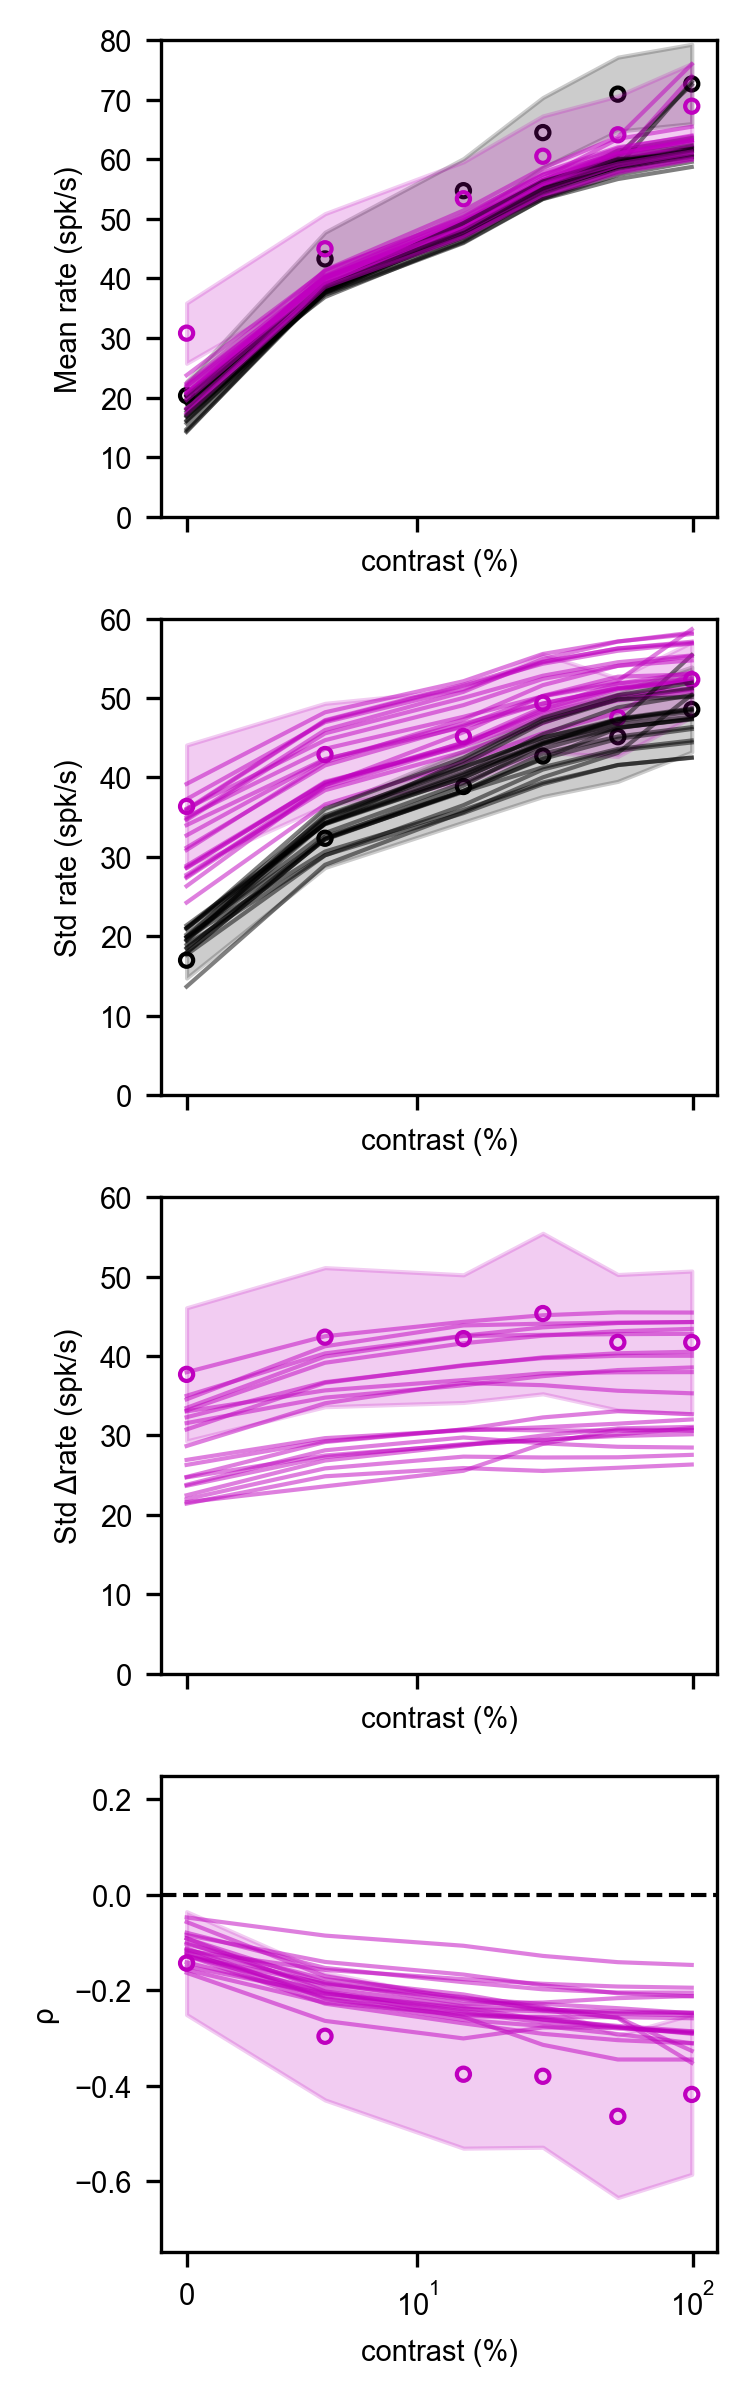

In [9]:
candidate_loss_cut = 25
chosen_idxs = candidate_costs < candidate_loss_cut
# chosen_idxs = np.logical_and(candidate_costs < candidate_loss_cut,candidate_in_bars[:,-1])
# chosen_idxs = np.logical_and(candidate_costs < candidate_loss_cut,np.logical_and(candidate_in_bars[:,-2],candidate_in_bars[:,-1]))
# chosen_idxs = np.all(candidate_in_bars,1)
# chosen_idxs = np.logical_and(candidate_in_bars[:,-2],candidate_in_bars[:,-1])
# chosen_idxs = np.logical_and(candidate_preds[:,-1,4] > 32,candidate_preds[:,-1,5] < -0.25)
# chosen_idxs = np.logical_and([True if file[0] is not None and 'results_ring_perturb_njob-291_nrep-1' in file[0] else False for file in candidate_idxs],np.logical_and(candidate_preds[:,-1,4] > 35,candidate_preds[:,-1,5] < -0.3))
print(candidate_idxs[chosen_idxs])

plot_many_preds([candidate_vsm_preds[chosen_idxs],
                 candidate_vsm_preds[chosen_idxs]],'./../plots','candidate_fits_vsm',animal='monkey',
    plot_delta_r=False)

[['results_ring_perturb_njob-133_nrep-0_ntry-79.pkl' '3']
 ['results_ring_perturb_njob-291_nrep-1_ntry-297.pkl' '2']
 ['results_ring_perturb_njob-133_nrep-0_ntry-240.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-239.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-218.pkl' '1']
 ['results_ring_perturb_njob-133_nrep-0_ntry-258.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-248.pkl' '3']
 ['results_ring_perturb_njob-291_nrep-1_ntry-215.pkl' '1']
 ['results_ring_perturb_njob-133_nrep-0_ntry-205.pkl' '0']
 ['results_ring_perturb_njob-133_nrep-0_ntry-298.pkl' '0']
 ['results_ring_perturb_njob-291_nrep-1_ntry-289.pkl' '0']
 ['results_ring_347.pkl' '8']
 ['results_ring_perturb_njob-133_nrep-0_ntry-203.pkl' '2']
 ['results_ring_perturb_njob-133_nrep-0_ntry-231.pkl' '0']
 ['results_ring_perturb_njob-291_nrep-1_ntry-255.pkl' '3']
 ['results_ring_perturb_njob-291_nrep-1_ntry-252.pkl' '0']
 ['results_ring_perturb_njob-291_nrep-1_ntry-59.pkl' '2']
 ['results_ring_291.pkl' '1'

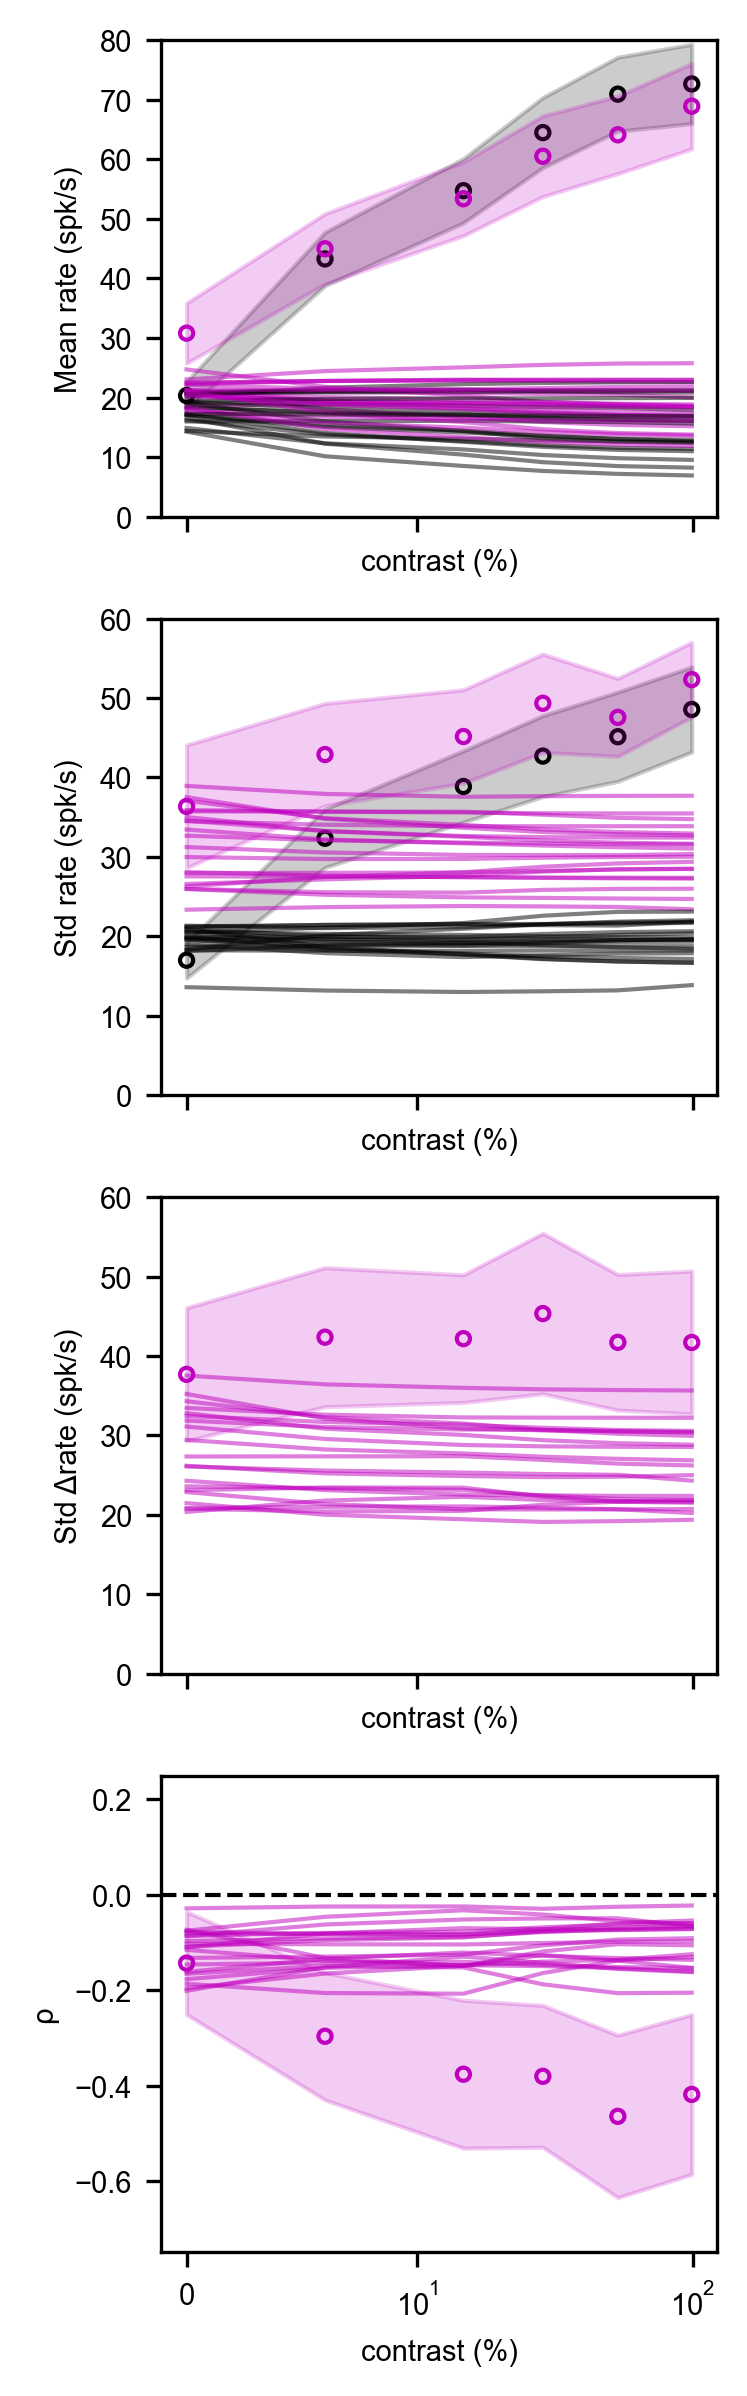

In [10]:
candidate_loss_cut = 25
chosen_idxs = candidate_costs < candidate_loss_cut
# chosen_idxs = np.logical_and(candidate_costs < candidate_loss_cut,candidate_in_bars[:,-1])
# chosen_idxs = np.logical_and(candidate_costs < candidate_loss_cut,np.logical_and(candidate_in_bars[:,-2],candidate_in_bars[:,-1]))
# chosen_idxs = np.all(candidate_in_bars,1)
# chosen_idxs = np.logical_and(candidate_in_bars[:,-2],candidate_in_bars[:,-1])
# chosen_idxs = np.logical_and(candidate_preds[:,-1,4] > 32,candidate_preds[:,-1,5] < -0.25)
# chosen_idxs = np.logical_and([True if file[0] is not None and 'results_ring_perturb_njob-291_nrep-1' in file[0] else False for file in candidate_idxs],np.logical_and(candidate_preds[:,-1,4] > 35,candidate_preds[:,-1,5] < -0.3))
print(candidate_idxs[chosen_idxs])

plot_many_preds([candidate_osm_preds[chosen_idxs],
                 candidate_osm_preds[chosen_idxs]],'./../plots','candidate_fits_osm',animal='monkey',
    plot_delta_r=False)

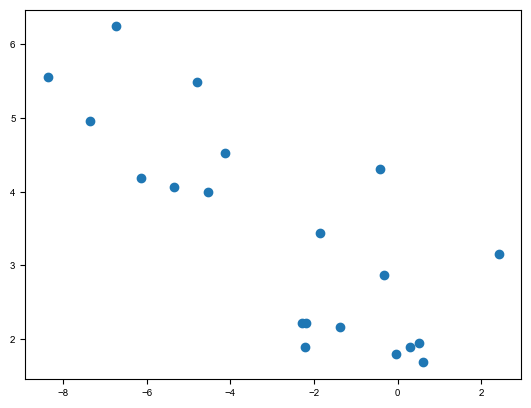

In [169]:
plt.scatter(candidate_osm_preds[chosen_idxs][:,-1,0] - candidate_osm_preds[chosen_idxs][:, 0,0],
            candidate_osm_preds[chosen_idxs][:,-1,-1])

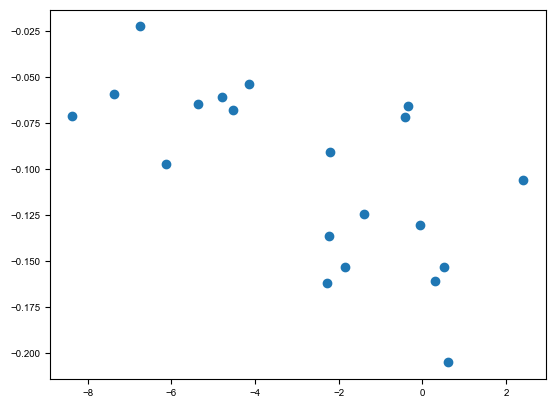

In [170]:
plt.scatter(candidate_osm_preds[chosen_idxs][:,-1,0] - candidate_osm_preds[chosen_idxs][:, 0,0],
            candidate_osm_preds[chosen_idxs][:,-1,5])

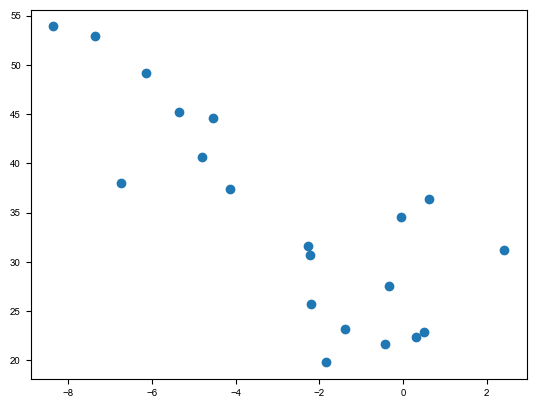

In [171]:
plt.scatter(candidate_osm_preds[chosen_idxs][:,-1,0] - candidate_osm_preds[chosen_idxs][:, 0,0],
            candidate_prms[chosen_idxs][:,1])

In [131]:
candidate_prms[20]

array([43.64874397, 19.76276606, 18.31978351, -3.71439337, -0.85042955,
        4.81951634,  2.60642656,  3.49839443,  0.14751927,  5.48267588,
        0.51239088])